In [1]:
from setup_triton import setup_triton

# TRITON_INTERPRET=1 uses a python interpreter instead of running on the GPU. 
# This menas that uou can insert Python breakpoints to debug your kernel code! 
setup_triton(use_interpreter=False)

# Triton Puzzle 8: Sparsemax Attention

This notebook implements sparsemax attention, a sparse alternative to softmax attention that produces exact zeros in the attention weights. Sparsemax is a special case of entmax with α=2.

## Key Concepts

- Sparsemax: A sparse activation function that projects onto the probability simplex
- Bisection Algorithm: Efficiently finds the threshold τ for sparsity
- Attention Sparsity: Many attention weights become exactly zero
- Memory Efficiency: Fused kernels avoid materializing large attention matrices

In [2]:
import torch
import triton
import triton.language as tl
import numpy as np
from IPython.display import display, Image

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Set random seed
torch.manual_seed(42)

Using device: cuda


## Implementation 1: Naive PyTorch

First, let's see the standard implementation:

In [4]:
from entmax import entmax_bisect, sparsemax

def attention_naive(Q, K, V, causal=False):
    """
    Naive attention implementation.
    Creates the full N×N attention matrix.
    
    Args:
        Q, K, V: (B, H, N, d) tensors
        causal: whether to apply causal mask
    """
    B, H, N, d = Q.shape
    
    # Compute attention scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) / (d ** 0.5)  # (B, H, N, N)
    
    # Apply causal mask if needed
    if causal:
        mask = torch.triu(torch.ones(N, N, device=Q.device), diagonal=1).bool()
        scores.masked_fill_(mask[None, None, :, :], float('-inf'))
    
    # Apply softmax
    attn_weights = sparsemax(scores, dim=-1)  # (B, H, N, N)
    
    # Compute output
    out = torch.matmul(attn_weights, V)  # (B, H, N, d)
    
    return out


def attention_naive_bisect(Q, K, V, causal=False):
    B, H, N, d = Q.shape
    scores = torch.matmul(Q, K.transpose(-2, -1)) / (d ** 0.5)  # (B, H, N, N)
    if causal:
        mask = torch.triu(torch.ones(N, N, device=Q.device), diagonal=1).bool()
        scores.masked_fill_(mask[None, None, :, :], float('-inf'))
    attn_weights = entmax_bisect(scores, dim=-1, n_iter=20)  # (B, H, N, N)
    out = torch.matmul(attn_weights, V)  # (B, H, N, d)
    return out

## Implementation 2: AdaSplash

PyTorch's scaled_dot_product_attention (introduced in PyTorch 2.0):

In [5]:
!pip3 install adasplash

In [7]:
from adasplash import adasplash, adasplash_no_block_mask

def attention_pytorch(Q, K, V, causal=False):
    return adasplash_no_block_mask(Q, K, V, alpha=2.0, niter=3)

## Implementation 3: PyTorch Compiled



In [8]:
@torch.compile
def entmax_transform_compiled(x, tau, alpha):
    return torch.relu(x - tau) ** (1 / (alpha - 1))

@torch.compile
def entmax_compiled(z, alpha=1.5, dim=-1, n_iter=50):
    x = (alpha - 1) * z
    max_val = x.max()
    tau_lower = max_val - 1
    tau_upper = max_val - x.size(0) ** (1 - alpha)
    for _ in range(n_iter):
        tau = (tau_lower + tau_upper) / 2
        p = entmax_transform_compiled(x, tau, alpha)  # Creates intermediate tensor!
        if p.sum() > 1:  # Read entire p to compute sum
            tau_lower = tau
        else:
            tau_upper = tau
    p = entmax_transform_compiled(x, tau, alpha)
    return p

@torch.compile
def attention_compiled(Q, K, V, causal=False):
    """Compiled attention."""
    B, H, N, d = Q.shape
    scores = torch.matmul(Q, K.transpose(-2, -1)) / (d ** 0.5)
    if causal:
        mask = torch.triu(torch.ones(N, N, device=Q.device), diagonal=1).bool()
        scores.masked_fill_(mask, float('-inf'))
    attn_weights = entmax_compiled(scores, alpha=2.0, dim=-1, n_iter=20)
    out = torch.matmul(attn_weights, V)
    return out

## Implementation 4: Triton Kernel (Puzzle)

Now implement memory-efficient attention!

### Version 1: Block-wise Attention (Starter)

In [28]:
@triton.jit
def sparsemax_attention_kernel_v1(
    Q_ptr, K_ptr, V_ptr, Out_ptr,
    B, H, N, d,
    scale,
    n_iter,
    stride_qb, stride_qh, stride_qn, stride_qd,
    stride_kb, stride_kh, stride_kn, stride_kd,
    stride_vb, stride_vh, stride_vn, stride_vd,
    stride_ob, stride_oh, stride_on, stride_od,
    causal: tl.constexpr,
    BLOCK_N: tl.constexpr,
    BLOCK_D: tl.constexpr,
):
    """Simple sparsemax attention - one program per query."""
    # Get program ID and decode indices
    pid = tl.program_id(0)
    
    # Decode batch, head, and query indices
    query_idx = pid % N
    head_idx = (pid // N) % H
    batch_idx = pid // (N * H)
    
    # Pointers
    Q_ptr += batch_idx * stride_qb + head_idx * stride_qh + query_idx * stride_qn
    K_ptr += batch_idx * stride_kb + head_idx * stride_kh
    V_ptr += batch_idx * stride_vb + head_idx * stride_vh
    Out_ptr += batch_idx * stride_ob + head_idx * stride_oh + query_idx * stride_on
    
    # Load query vector
    offs_d = tl.arange(0, BLOCK_D)
    mask_d = offs_d < d
    q = tl.load(Q_ptr + offs_d * stride_qd, mask=mask_d, other=0.0)
    
    # First pass: find max score
    max_score = -float('inf')
    
    for start_n in range(0, N, BLOCK_N):
        offs_n = start_n + tl.arange(0, BLOCK_N)
        mask_n = offs_n < N
        
        # Causal mask
        if causal:
            mask_n = mask_n & (offs_n <= query_idx)
        
        # Load keys
        k_ptrs = K_ptr + offs_n[:, None] * stride_kn + offs_d[None, :] * stride_kd
        k = tl.load(k_ptrs, mask=mask_n[:, None] & mask_d[None, :], other=0.0)
        
        # Compute scores
        scores = tl.sum(q[None, :] * k, axis=1) * scale
        scores = tl.where(mask_n, scores, -float('inf'))
        
        # Update max
        block_max = tl.max(scores, axis=0)
        max_score = tl.maximum(max_score, block_max)
    
    # Bisection to find tau
    tau_lower = max_score - 1.0
    tau_upper = max_score - 1.0 / N
    
    for _ in range(n_iter):
        tau = (tau_lower + tau_upper) / 2.0
        sum_weights = 0.0
        
        # Compute sum of positive (score - tau)
        for start_n in range(0, N, BLOCK_N):
            offs_n = start_n + tl.arange(0, BLOCK_N)
            mask_n = offs_n < N
            
            if causal:
                mask_n = mask_n & (offs_n <= query_idx)
            
            # Recompute scores
            k_ptrs = K_ptr + offs_n[:, None] * stride_kn + offs_d[None, :] * stride_kd
            k = tl.load(k_ptrs, mask=mask_n[:, None] & mask_d[None, :], other=0.0)
            scores = tl.sum(q[None, :] * k, axis=1) * scale
            scores = tl.where(mask_n, scores, -float('inf'))
            
            # Sparsemax: max(0, score - tau)
            weights = tl.maximum(0.0, scores - tau)
            sum_weights += tl.sum(weights)
        
        # Update bounds
        if sum_weights > 1.0:
            tau_lower = tau
        else:
            tau_upper = tau
    
    # Final tau
    tau = (tau_lower + tau_upper) / 2.0
    
    # Compute weighted sum with final tau
    acc = tl.zeros((BLOCK_D,), dtype=tl.float32)
    
    for start_n in range(0, N, BLOCK_N):
        offs_n = start_n + tl.arange(0, BLOCK_N)
        mask_n = offs_n < N
        
        if causal:
            mask_n = mask_n & (offs_n <= query_idx)
        
        # Recompute scores and weights
        k_ptrs = K_ptr + offs_n[:, None] * stride_kn + offs_d[None, :] * stride_kd
        k = tl.load(k_ptrs, mask=mask_n[:, None] & mask_d[None, :], other=0.0)
        scores = tl.sum(q[None, :] * k, axis=1) * scale
        scores = tl.where(mask_n, scores, -float('inf'))
        
        # Final sparsemax weights
        weights = tl.maximum(0.0, scores - tau)

        # Leverage sparsity to skip full-zero blocks
        has_nonzero = tl.sum((weights > 0).to(tl.float32)) > 0

        if has_nonzero:
            # Load values and accumulate
            v_ptrs = V_ptr + offs_n[:, None] * stride_vn + offs_d[None, :] * stride_vd
            v = tl.load(v_ptrs, mask=mask_n[:, None] & mask_d[None, :], other=0.0)
            
            acc += tl.sum(weights[:, None] * v, axis=0)
    
    # Store output
    tl.store(Out_ptr + offs_d * stride_od, acc, mask=mask_d)


def attention_triton_v1(Q, K, V, causal=False, n_iter=50):
    """Wrapper for simple sparsemax attention kernel."""
    assert Q.shape == K.shape
    assert K.shape[-1] == V.shape[-1]
    B, H, N, d = Q.shape
    scale = 1.0 / (d**0.5)
    
    # Allocate output
    Out = torch.empty_like(Q)
    
    # Ensure contiguity
    Q = Q.contiguous()
    K = K.contiguous()
    V = V.contiguous()
    
    # Block sizes
    BLOCK_N = min(triton.next_power_of_2(N), 1024)
    BLOCK_D = triton.next_power_of_2(d)
    
    # Launch kernel
    grid = (B * H * N,)
    
    sparsemax_attention_kernel_v1[grid](
        Q, K, V, Out,
        B, H, N, d,
        scale,
        n_iter,
        Q.stride(0), Q.stride(1), Q.stride(2), Q.stride(3),
        K.stride(0), K.stride(1), K.stride(2), K.stride(3),
        V.stride(0), V.stride(1), V.stride(2), V.stride(3),
        Out.stride(0), Out.stride(1), Out.stride(2), Out.stride(3),
        causal,
        BLOCK_N, 
        BLOCK_D,
    )
    
    return Out

### Version 2: Flash Attention Style (Advanced)

In [29]:
@triton.jit
def sparsemax_attention_kernel_v2(
    Q_ptr, K_ptr, V_ptr, Out_ptr,
    B, H, N, d,
    scale,
    n_iter,
    stride_qb, stride_qh, stride_qn, stride_qd,
    stride_kb, stride_kh, stride_kn, stride_kd,
    stride_vb, stride_vh, stride_vn, stride_vd,
    stride_ob, stride_oh, stride_on, stride_od,
    causal: tl.constexpr,
    BLOCK_M: tl.constexpr,
    BLOCK_N: tl.constexpr,
    BLOCK_D: tl.constexpr,
):
    """
    Flash-style sparsemax attention - each program handles BLOCK_M queries.
    """
    # Program ID
    pid_m = tl.program_id(0)
    pid_bh = tl.program_id(1)
    
    # Decode batch and head
    batch_idx = pid_bh // H
    head_idx = pid_bh % H
    
    # Query block this program handles
    offs_m = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_d = tl.arange(0, BLOCK_D)
    
    # Initialize pointers
    Q_block_ptr = Q_ptr + batch_idx * stride_qb + head_idx * stride_qh
    K_block_ptr = K_ptr + batch_idx * stride_kb + head_idx * stride_kh
    V_block_ptr = V_ptr + batch_idx * stride_vb + head_idx * stride_vh
    O_block_ptr = Out_ptr + batch_idx * stride_ob + head_idx * stride_oh
    
    # Load queries [BLOCK_M, d]
    mask_m = offs_m < N
    mask_d = offs_d < d
    q_ptrs = Q_block_ptr + offs_m[:, None] * stride_qn + offs_d[None, :] * stride_qd
    q = tl.load(q_ptrs, mask=mask_m[:, None] & mask_d[None, :], other=0.0)
    
    # For each query in the block, we need to find its tau
    # First, find max scores for each query
    max_scores = tl.full([BLOCK_M], value=-float('inf'), dtype=tl.float32)
    
    for start_n in range(0, N, BLOCK_N):
        offs_n = start_n + tl.arange(0, BLOCK_N)
        mask_n = offs_n < N
        
        # Load keys
        k_ptrs = K_block_ptr + offs_n[None, :] * stride_kn + offs_d[:, None] * stride_kd
        k = tl.load(k_ptrs, mask=mask_d[:, None] & mask_n[None, :], other=0.0)
        
        # Compute scores [BLOCK_M, BLOCK_N]
        scores = tl.dot(q, k, out_dtype=tl.float32) * scale
        
        # Apply causal mask
        if causal:
            mask_causal = offs_m[:, None] >= offs_n[None, :]
            scores = tl.where(mask_causal & mask_n[None, :], scores, -float('inf'))
        else:
            scores = tl.where(mask_n[None, :], scores, -float('inf'))
        
        # Update max scores
        block_max = tl.max(scores, axis=1)
        max_scores = tl.maximum(max_scores, block_max)
    
    # Bisection for each query's tau
    tau_lower = max_scores - 1.0
    tau_upper = max_scores - 1.0 / N
    
    for _ in range(n_iter):
        tau = (tau_lower + tau_upper) / 2.0
        sum_weights = tl.zeros([BLOCK_M], dtype=tl.float32)
        
        for start_n in range(0, N, BLOCK_N):
            offs_n = start_n + tl.arange(0, BLOCK_N)
            mask_n = offs_n < N
            
            # Recompute scores
            k_ptrs = K_block_ptr + offs_n[None, :] * stride_kn + offs_d[:, None] * stride_kd
            k = tl.load(k_ptrs, mask=mask_d[:, None] & mask_n[None, :], other=0.0)
            scores = tl.dot(q, k, out_dtype=tl.float32) * scale
            
            if causal:
                mask_causal = offs_m[:, None] >= offs_n[None, :]
                scores = tl.where(mask_causal & mask_n[None, :], scores, -float('inf'))
            else:
                scores = tl.where(mask_n[None, :], scores, -float('inf'))
            
            # Sparsemax weights
            weights = tl.maximum(0.0, scores - tau[:, None])
            sum_weights += tl.sum(weights, axis=1)
        
        # Update bounds
        mask_update = sum_weights > 1.0
        tau_lower = tl.where(mask_update, tau, tau_lower)
        tau_upper = tl.where(mask_update, tau_upper, tau)
    
    # Final tau
    tau = (tau_lower + tau_upper) / 2.0
    
    # Compute output with final tau
    acc = tl.zeros([BLOCK_M, BLOCK_D], dtype=tl.float32)
    
    for start_n in range(0, N, BLOCK_N):
        offs_n = start_n + tl.arange(0, BLOCK_N)
        mask_n = offs_n < N
        
        # Final scores and weights
        k_ptrs = K_block_ptr + offs_n[None, :] * stride_kn + offs_d[:, None] * stride_kd
        k = tl.load(k_ptrs, mask=mask_d[:, None] & mask_n[None, :], other=0.0)
        scores = tl.dot(q, k, out_dtype=tl.float32) * scale
        
        if causal:
            mask_causal = offs_m[:, None] >= offs_n[None, :]
            scores = tl.where(mask_causal & mask_n[None, :], scores, -float('inf'))
        else:
            scores = tl.where(mask_n[None, :], scores, -float('inf'))
        
        weights = tl.maximum(0.0, scores - tau[:, None])

        # Leverage sparsity to skip full-zero blocks
        has_nonzero = tl.sum((weights > 0).to(tl.float32)) > 0
        if has_nonzero:
            # Load values and accumulate
            v_ptrs = V_block_ptr + offs_n[:, None] * stride_vn + offs_d[None, :] * stride_vd
            v = tl.load(v_ptrs, mask=mask_n[:, None] & mask_d[None, :], other=0.0)
            
            acc += tl.dot(weights, v, out_dtype=tl.float32)
    
    # Store output
    o_ptrs = O_block_ptr + offs_m[:, None] * stride_on + offs_d[None, :] * stride_od
    tl.store(o_ptrs, acc, mask=mask_m[:, None] & mask_d[None, :])


def attention_triton_v2(Q, K, V, causal=False, n_iter=50):
    """Flash-style sparsemax attention implementation."""
    assert Q.shape == K.shape
    assert K.shape[-1] == V.shape[-1]
    B, H, N, d = Q.shape
    scale = 1.0 / (d**0.5)

    # Allocate output
    Out = torch.empty_like(Q)

    # Ensure contiguity
    Q = Q.contiguous()
    K = K.contiguous()
    V = V.contiguous()
    
    # Block sizes
    BLOCK_M = min(triton.next_power_of_2(N), 64)
    BLOCK_N = min(triton.next_power_of_2(N), 64)
    BLOCK_D = triton.next_power_of_2(d)
    
    grid = (triton.cdiv(N, BLOCK_M), B * H)
    
    sparsemax_attention_kernel_v2[grid](
        Q, K, V, Out,
        B, H, N, d,
        scale,
        n_iter,
        Q.stride(0), Q.stride(1), Q.stride(2), Q.stride(3),
        K.stride(0), K.stride(1), K.stride(2), K.stride(3),
        V.stride(0), V.stride(1), V.stride(2), V.stride(3),
        Out.stride(0), Out.stride(1), Out.stride(2), Out.stride(3),
        causal,
        BLOCK_M, 
        BLOCK_N, 
        BLOCK_D,
    )

    return Out

## Testing Correctness

### Version 1

✅ Test PASSED! (non-causal)
   Shape: (B=2, H=4, N=128, d=64)
   Max error: 4.50e-06
✅ Test PASSED! (causal)
   Shape: (B=2, H=4, N=128, d=64)
   Max error: 3.96e-06

🎉 Congratulations! Your implementation is correct!


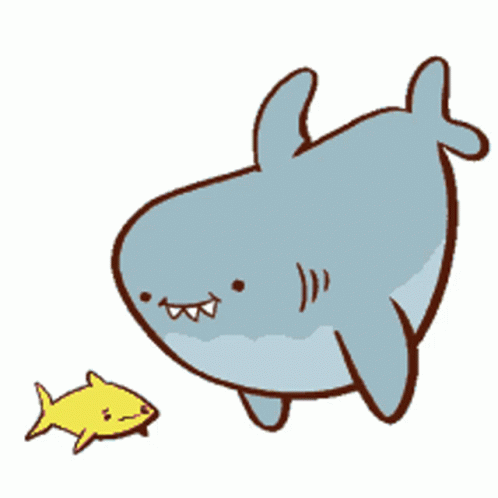

In [30]:
def test_attention(B=2, H=4, N=128, d=64, causal=False, atol=1e-2, rtol=1e-2):
    """Test attention implementation against PyTorch."""
    torch.manual_seed(42)
    
    # Generate random inputs
    Q = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    K = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    V = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    
    # PyTorch reference
    expected = attention_naive(Q, K, V, causal=causal)
    
    # Triton implementation
    actual = attention_triton_v1(Q, K, V, causal=causal)
    
    try:
        torch.testing.assert_close(actual, expected, atol=atol, rtol=rtol)
        print(f"✅ Test PASSED! ({'causal' if causal else 'non-causal'})")
        print(f"   Shape: (B={B}, H={H}, N={N}, d={d})")
        print(f"   Max error: {(actual - expected).abs().max().item():.2e}")
        return True
    except AssertionError as e:
        print(f"❌ Test FAILED!")
        print(f"   Error: {e}")
        return False

# Test both causal and non-causal
test_passed = test_attention(causal=False)
test_passed &= test_attention(causal=True)

# Display congrats message
if test_passed:
    print("\n🎉 Congratulations! Your implementation is correct!")
    display(Image("figs/success.gif", width=256, height=256))

### Version 2

✅ Test PASSED! (non-causal)
   Shape: (B=2, H=4, N=128, d=64)
   Max error: 1.91e-06
✅ Test PASSED! (causal)
   Shape: (B=2, H=4, N=128, d=64)
   Max error: 1.43e-06

🎉 Congratulations! Your implementation is correct!


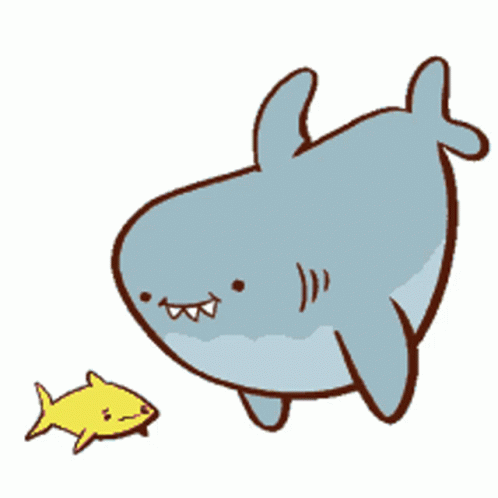

In [31]:
def test_attention(B=2, H=4, N=128, d=64, causal=False, atol=1e-2, rtol=1e-2):
    """Test attention implementation against PyTorch."""
    torch.manual_seed(42)
    
    # Generate random inputs
    Q = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    K = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    V = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    
    # PyTorch reference
    expected = attention_naive(Q, K, V, causal=causal)
    
    # Triton implementation
    actual = attention_triton_v2(Q, K, V, causal=causal)
    
    try:
        torch.testing.assert_close(actual, expected, atol=atol, rtol=rtol)
        print(f"✅ Test PASSED! ({'causal' if causal else 'non-causal'})")
        print(f"   Shape: (B={B}, H={H}, N={N}, d={d})")
        print(f"   Max error: {(actual - expected).abs().max().item():.2e}")
        return True
    except AssertionError as e:
        print(f"❌ Test FAILED!")
        print(f"   Error: {e}")
        return False

# Test both causal and non-causal
test_passed = test_attention(causal=False)
test_passed &= test_attention(causal=True)

# Display congrats message
if test_passed:
    print("\n🎉 Congratulations! Your implementation is correct!")
    display(Image("figs/success.gif", width=256, height=256))

---

## Benchmarking (GPU only)

Running benchmarks...
[OOM] provider=naive, N=16384 -- Skipping (out of memory)
[OOM] provider=naive_bisect, N=16384 -- Skipping (out of memory)


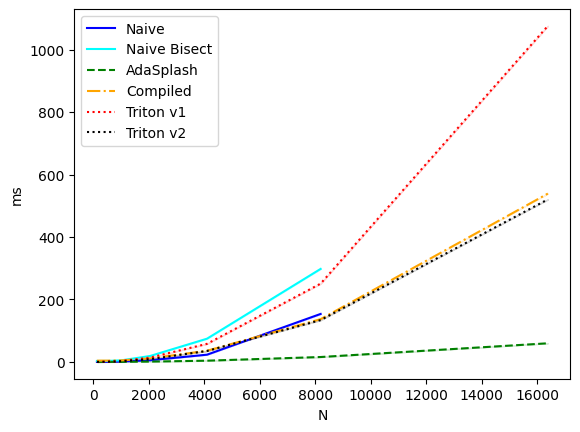

attention-performance:
         N       Naive  Naive Bisect  AdaSplash    Compiled    Triton v1   Triton v2
0    128.0    0.124096      3.154784   0.065936    4.050080     0.077280    0.190752
1    256.0    0.187648      3.114480   0.087120    4.198400     0.216160    0.370656
2    512.0    0.455152      3.151520   0.156320    4.223136     0.749152    0.764928
3   1024.0    1.447936      5.308416   0.372928    5.138656     2.989568    2.383776
4   2048.0    5.486656     19.140480   1.095680   11.355904    14.077408    8.854000
5   4096.0   23.256768     74.440445   4.017776   35.878384    58.002174   35.154913
6   8192.0  153.734375    297.875458  15.776752  137.005798   250.775040  133.962524
7  16384.0         NaN           NaN  59.716415  539.013245  1075.896362  520.419922


In [33]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # Sequence length
        x_vals=[128, 256, 512, 1024, 2048, 4096,  8192, 16384], #32768, 65536],
        line_arg='provider',
        line_vals=['naive', 'naive_bisect', 'adasplash', 'compiled', 'triton_v1', 'triton_v2'],
        line_names=['Naive', 'Naive Bisect', 'AdaSplash', 'Compiled', 'Triton v1', 'Triton v2'],
        styles=[('blue', '-'), ('cyan', '-'), ('green', '--'), ('orange', '-.'), ('red', ':'), ('black', ':')],
        ylabel='ms',
        plot_name='attention-performance',
        args={'B': 2, 'H': 2, 'd': 16, 'causal': True},  # feel free to edit these values!
    )
)
def benchmark(N, B, H, d, causal, provider):
    """Benchmark attention implementations."""
    Q = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    K = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    V = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)

    quantiles = [0.5, 0.05, 0.95]

    try:
        if provider == 'naive':
            ms, min_ms, max_ms = triton.testing.do_bench(
                lambda: attention_naive(Q, K, V, causal=causal), quantiles=quantiles
            )
        elif provider == 'naive_bisect':
            ms, min_ms, max_ms = triton.testing.do_bench(
                lambda: attention_naive_bisect(Q, K, V, causal=causal), quantiles=quantiles
            )
        elif provider == 'adasplash':
            ms, min_ms, max_ms = triton.testing.do_bench(
                lambda: attention_pytorch(Q, K, V, causal=causal), quantiles=quantiles
            )
        elif provider == 'compiled':
            ms, min_ms, max_ms = triton.testing.do_bench(
                lambda: attention_compiled(Q, K, V, causal=causal), quantiles=quantiles
            )
        elif provider == 'triton_v1':
            ms, min_ms, max_ms = triton.testing.do_bench(
                lambda: attention_triton_v1(Q, K, V, causal=causal), quantiles=quantiles
            )
        elif provider == 'triton_v2':
            ms, min_ms, max_ms = triton.testing.do_bench(
                lambda: attention_triton_v2(Q, K, V, causal=causal), quantiles=quantiles
            )
        return ms, max_ms, min_ms
    except RuntimeError as e:
        if 'out of memory' in str(e).lower():
            print(f"[OOM] provider={provider}, N={N} -- Skipping (out of memory)")
            torch.cuda.empty_cache()  # Free up memory before next run!
            return float('nan'), float('nan'), float('nan')
        else:
            print(f"[ERROR] provider={provider}, N={N} -- {e}")
            return float('nan'), float('nan'), float('nan')


print("Running benchmarks...")
results = benchmark.run(show_plots=True, print_data=True, return_df=True, save_path='')

## Speedup?

In [40]:
# Check if Triton is faster than PyTorch
avg_adasplash = results['AdaSplash'].mean()
avg_triton = results['Triton v2'].mean()
speedup = avg_pytorch / avg_triton

if avg_triton < avg_adasplash :
    speedup = avg_adasplash / avg_triton
    print(f"\n🚀 Awesome! Triton is {speedup:.2f}x faster than AdaSplash!")
    display(Image("figs/gpu.gif", width=400, height=256))
else:
    speedup = avg_adasplash / avg_triton
    print(f"\n🐌 Not quite yet! Triton implementation is {speedup:.2f}x slower than AdaSplash!")


🐌 Not quite yet! Triton implementation is 0.12x slower than AdaSplash!



🚀 Awesome! Triton is 2.24x faster than Naive!


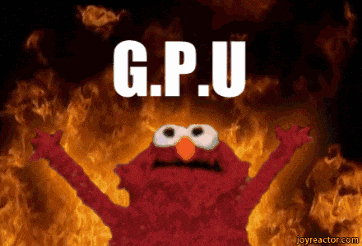

In [44]:
# Check if Triton is faster than PyTorch
avg_adasplash = results['Naive Bisect'][:-1].mean()
avg_triton = results['Triton v2'][:-1].mean()
speedup = avg_pytorch / avg_triton

if avg_triton < avg_adasplash :
    speedup = avg_adasplash / avg_triton
    print(f"\n🚀 Awesome! Triton is {speedup:.2f}x faster than Naive!")
    display(Image("figs/gpu.gif", width=400, height=256))
else:
    speedup = avg_adasplash / avg_triton
    print(f"\n🐌 Not quite yet! Triton implementation is {speedup:.2f}x slower than AdaSplash!")

---

## Summary


### Performance Results
- Triton V2 (Flash-style) is fastest, achieving up to ~3.3x speedup over naive implementation
- Memory efficiency: Fused kernels avoid materializing N×N attention matrices
- Scaling: Performance gap increases with sequence length

### Sparsity Benefits
- Sparsemax produces lots of exact zeros vs softmax's dense weights
- Potential for sparse matrix optimizations in downstream computations

### Implementation Trade-offs


| Aspect | Softmax Attention | Sparsemax Attention |
|--------|-------------------|---------------------|
| **Computation** | Single pass | Multiple passes (bisection) |
| **Memory reads** | O(Nd) | O(n_iter * Nd) |
| **Sparsity** | Dense (all non-zero) | Sparse (>90%+ zeros) |
| **Differentiability** | Smooth everywhere | Non-smooth at boundaries |

### When to Use Sparsemax Attention
- Interpretability: When you need clear, sparse attention patterns
- Long sequences: Sparsity becomes more pronounced with larger N
- Memory constraints: When subsequent operations can exploit sparsity
- Robustness: Less sensitive to attention weight perturbations and dispersion

### Future Optimizations
- Adaptive iterations: Faster convergence methods for tau 
- Sparse storage: Only store/compute non-zero weights per-row
- Approximate algorithms: Faster alternatives to bisection
- Hardware acceleration: Leverage sparse tensor cores if possible

<center>
    <b><span style="font-size: 24px">Flash Swim, Sardine!</span></b>
    <br>
    <img src="./figs/sardine-super-swim.png" width="512" />
</center>